(scheme:upwind)=
# The Upwind Scheme

Observation of {numref}`leapfrogDomain` indicates that, for $c>0$, information travels from left to right so the grid nodes to the right of $x_m$ do not provide useful information to the solution at $x_m$. In this case, a numerical scheme may be constructed that only uses the information **upwind** from $x_m$:

$$
   u_{m}^{n+1} = u_{m}^{n} - c\frac{\Delta t}{\Delta x}(u_{m}^{n}-u_{m-1}^{n})
$$ (eqUpwind)

where $u_{m}^{n}$, $\Delta t$ and $\Delta x$ have the same meaning as for the Leapfrog scheme.

The upwind scheme {eq}`eqUpwind` depends on the sign of $c$. For $c<0$, the scheme becomes

$$
   u_{m}^{n+1} = u_{m}^{n} - c\frac{\Delta t}{\Delta x}(u_{m+1}^{n}-u_{m}^{n})
$$ (eqDownwind)

as information is travelling from right to left.

## Consistency, stability and convergence
The scheme's truncation error is $O(\Delta t,\Delta x)$, as it used a forward formula for the time derivative and a backward formula for the space derivative (forward if $c<0$) 

### Stability

The stability of the Upwind scheme can be determined by the von Neumann method. Assuming a solution of the form $u_m^n=B^n e^{i\lambda m\Delta x}$ and substituting in the difference equation {eq}`eqUpwind` we obtain

$$
	u_m^{n+1}=\left[1-\sigma \left(1-e^{-i\lambda \Delta x}\right)\right]u_m^n
$$

where $\sigma=c\frac{\Delta t}{\Delta x}$. Therefore, the amplification factor is $G=\left[1-\sigma \left(1-e^{-i\lambda \Delta x}\right)\right]$, whose norm is $|G|^2=1-2\sigma\left(1-\cos\lambda\Delta x\right)\left(1-\sigma\right)$. Depending on the value of sigma we can have the following cases:
1. $\sigma=0 \lor \sigma=1$: $|G|^2=1$ and the scheme is **neutral** (stable).
2. $\sigma<0 \lor \sigma>1$: $|G|^2>1$ and the scheme is **amplifying** (unstable).
3. $\sigma>0 \land \sigma<1$: $|G|^2=1$ and the scheme is **damping** (stable).

Note that case 2 encompasses two distinct situations. If $\sigma < 0$, the upwind formulation {eq}`eqUpwind` is being used in the situation where $c<0$ or {eq}`eqDownwind` is being used in the situation where $c>0$. When this occurs the scheme is referred to as **Downwind**. If $\sigma > 1$, the cause of instability is the same as for the Leapfrog scheme. 

```{figure} Upwind_Domain.png
---
height: 600px
name: upwindDomain
---
Domain of influence of the Upwind scheme. 
```
The scheme is conditionally stable with the stability condition being $c\frac{\Delta t}{\Delta x} \leq 1$. Its domain of dependence is shown in {numref}`upwindDomain`. The previously stable solution with $c<0$ is now an unstable solution, because the scheme is working as a *Downwind* scheme.

## Application: propagation of top hat function

To test the scheme, we are going to apply it to the propagation of the top hat signal, as we did with the Leapfrog scheme.

In [1]:
def topHat(x):
   f0=np.zeros(x.shape)
   f0[(x>0.45) & (x<0.55)]=1

   return f0

The Upwind scheme is implemented in the following Python function:

In [2]:
def upWind(u0,c,dt,dx,N,M):
    
    # Initial condition
    u=u0.copy()

    # CFL number
    C = c*dt/dx

    for l in range(0, N):
        
        # Inflow B.C.
        u[0]  = u[0] - C * (u[0] - u[M-1]) 
        # Interior/outflow points
        u[1 : M] = u[1 : M] - C * (u[1 : M] - u[0 : M - 1]) 
    
    return u

In the next code snippet, we set the discretization parameters and integrate the initial condition with the Upwind scheme:

In [3]:
import numpy as np
import matplotlib.pyplot as plt

N     = 30       # Number of time steps
M     = 100      # Number of grid points
c     = 0.75     # Propagation speed

dt = 0.01
dx = 1/M

print("Number of time steps = {:d}".format(N))
print("Number of grid points = {:d}".format(M))
print("Time step = {:f}".format(dt))
print("Grid size = {:f}".format(dx))
print("CFL number = {:f}".format(c*dt/dx))

# Grid points
X=np.linspace(0,1,M)

# Integrate the initial condition N time steps
U=upWind(topHat(X),c,dt,dx,N,M)

Number of time steps = 30
Number of grid points = 100
Time step = 0.010000
Grid size = 0.010000
CFL number = 0.750000


The solution at the end of the integration is shown below:

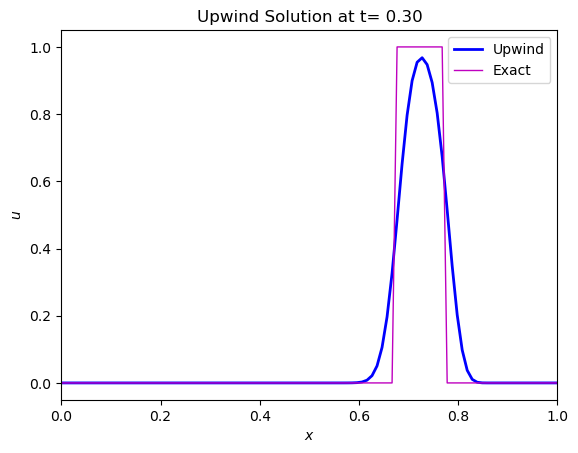

In [4]:
# Shift the exact solution a distance equivalent to c*N*dt
newX = np.mod(X-c*N*dt,1)

fig, ax0 = plt.subplots()

ax0.plot(X, U, lw = 2, color = "b",  label='Upwind')
ax0.plot(X, topHat(newX), lw = 1, color = "m",  label='Exact')

ax0.set_title("Upwind Solution at t={:5.2f}".format(N*dt))
ax0.set_xlabel('$x$')
ax0.set_xlim([0, 1])
ax0.set_ylabel('$u$')
ax0.legend()

plt.show()

Unlike the Leapfrog scheme, the solution with the Upwind scheme doesn't show dispersive behaviour. Instead, it presents an excessive smoothing of the abrupt transitions of the initial condition, an effect that is also undesirable. This is characteristic of the Upwind scheme, which is said to be **dissipative** (in excess).

The source of the dissipation can be identified in the Upwind scheme as an artificial term that is added to the linear advection equation {eq}`eqAdvection`

\begin{equation}
	\frac{\partial u}{\partial t} + c  \frac{\partial u}{\partial x} = \color{magenta}\left(1-\sigma \right) c\frac{\Delta x}{2}\frac{\partial^2 u}{\partial x^2} + O(\Delta t^2,\Delta x^2)
\end{equation}

The term has a diffusive character due to the 2nd derivative and therefore it is known as *artifical diffusion* or *numerical diffusion*. 

The coefficient $\left(1-\sigma \right) c\frac{\Delta x}{2}$ of the 2nd derivative is an analog of the physical diffusivity $D$ and can be regarded as an *artificial diffusivity*. 
The impact of the artificial diffusion will depend on its magnitude relative to the physical advection which is the process that is being modeled. This relative importance is measured by a *grid* Peclet number

$$
	\tilde{P}_e=\frac{cL}{c \Delta x (1-\sigma )/2}
$$ 

which should be $\gg1$ so as to minimize the effects of numerical diffusion.